## About the Topic
A backorder is an item that is not in stock at the moment. The customer can still order it, but delivery will only happen once the stock has been replenished. This is different from a situation when a product is labeled as being “out-of-stock” on the web platform which means the customer can’t order the product. However, backorders can still be placed despite the product not being in stock at a given moment in time. However, this causes a lot of additional inventory costs and wait for the customers, which is undesirable.

### Objective
The aim is to create a prediction model largely to identify whether items could be going out of stock or on backorder. This will help us to keep adequate or surplus stock of those products in order to meet demands of customers and not lose sales opportunities.

### Data Description
The list of all features and explanation of certain features (only unknown or technical jargons) in the features given the dataset have been provided below :
- **sku** : a stock keeping unit is a distinct type of item for sale, such as a product or service, and all attributes associated with the item type that distinguish it from other item types

- **national_inv**: The present inventory level of the product

- **lead_time** :  lead time in inventory management is the amount of time between when a purchase order is placed to replenish products and when the order is received in the warehouse. Order lead times can vary between suppliers; the more suppliers involved in the chain, the longer the lead time is likely to be.

- **in_transit_qty** : In transit inventory, also called transportation inventory or goods in transit, is any good shipped by a seller but not yet received by a buyer

- **forecast_3_month** : Forecasted sales of the product for the next 3 months.

- **forecast_6_month** : Forecasted sales of the product for the next 6 months.

- **forecast_9_month** : Forecasted sales of the product for the next 9 months.

- **sales_1_month** : Actual Sales of the product in the last 1 month.

- **sales_3_month** : Actual Sales of the product in the last 3 months.

- **sales_6_month** : Actual Sales of the product in the last 6 months.

- **sales_9_month** : Actual Sales of the product in the last 9 months.

- **min_bank**: Minimum amount of stock recommended to have.

- **potential_issue**: Any problem identified with the product or part.

- **pieces_past_due** : Assumption - The stock items that have been kept in stock for long time, past their expected life span.

- **perf_6_month_avg** : Average sales performance of product over last 6 months.

- **perf_12_month_avg**: Average sales performance of product over last 12 months.

- **local_bo_qty** : BO QTY in inventory managment refers to the Back Order Quantity. To find Back Order Quantity, divide the number of undeliverable orders by the total number of orders and multiply the result by 100.

- **deck_risk** : Assumption - It is the risk associated with keeping the items in stock and could relate to damage, shelf life, theft, etc. 
- oe_constraint
- **ppap_risk** : Short for Production Part Approval Process, it is a risk reduction process which is used as a risk classification and qualification process which is used to determine whether a production run will produce parts with consistency and repeatability. It is done prior to product release
- **stop_auto_buy** : Has the auto buy for the product, which was back ordered, cancelled.
- rev_stop

**TARGET FEATURE** : went_on_backorder - Whether an items was backordered or not

### Loading the Logger

In [1]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

fileHandler = logging.FileHandler("Logging.txt")
fileHandler.setLevel(logging.INFO)

consoleHandler = logging.StreamHandler()
consoleHandler.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s %(levelname)s-%(message)s',datefmt='%Y-%m-%d %H:%M:%S')

fileHandler.setFormatter(formatter)
consoleHandler.setFormatter(formatter)

logger.addHandler(fileHandler)
logger.addHandler(consoleHandler)

logger.info("New file")

2021-10-04 10:19:19 INFO-New file


### Importing the Pre-requisite Packages

In [2]:
# import sagemaker
# import boto3
# from sagemaker.amazon.amazon_estimator import logging, get_image_uri
# from sagemaker.session import s3_input,Session

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as exp
import warnings
import pickle
warnings.filterwarnings('ignore')
logger.info("All pre-requisite packages imported For Data Preparation")

2021-10-04 10:19:25 INFO-All pre-requisite packages imported For Data Preparation


# Data Preparation

In [3]:
X = pd.read_csv("Xsample.csv")
y = pd.read_csv("Ysample.csv")
y.replace({"No":0,"Yes":1},inplace=True)


In [4]:
X.shape

(1687860, 17)

In [5]:
y.shape

(1687860, 2)

In [6]:
X.drop(["Unnamed: 0","sku"],axis=1,inplace=True)
y.drop("Unnamed: 0",axis=1,inplace=True)
logger.info("Dropped unnamed column created and the stock keeping unit feature")

2021-10-04 10:19:29 INFO-Dropped unnamed column created and the stock keeping unit feature


In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder,PowerTransformer
from sklearn.model_selection import train_test_split

### NOTE - 

- We noted at the end of EDA that the imbalance in the target classes needs to be corrected. Due to a very high ratio difference between  backorders and non backorders , we have decided to undersample the non backorders

- However, since this project is going to be deployed on a large scale basis, we need to take care of the data leakage issue to maintain model generalizability and performance across train, test and unseen data passed by user.

- For this we will first split the data into train and test samples, perform required data preparation across the samples and combine them and then undersample. We do this so that we dont apply the fit methods on the entire data and apply fit on the train and transform the test samples.

- Following undersample, we will again split into train and test for model building.

## Splitting the data into train and test for preprocessing

In [8]:
logger.info("Splitting Data into train and test samples")
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.30,random_state=0,stratify=y)

2021-10-04 10:19:29 INFO-Splitting Data into train and test samples


## Treating the Missing Values

In [9]:
Xtrain.lead_time.isnull().sum() / len(Xtrain) * 100

5.9678273925901095

In [10]:
Xtrain.lead_time.value_counts()

8.0     477850
2.0     236227
12.0    139608
4.0      89957
9.0      86555
52.0     21147
3.0      11333
10.0      9829
0.0       7334
14.0      7216
16.0      6190
13.0      3799
6.0       3779
5.0       2839
15.0      2670
17.0      2634
11.0       788
20.0       282
30.0       211
18.0       153
7.0        148
22.0        96
24.0        74
26.0        74
28.0        64
40.0        36
21.0        31
35.0        25
19.0        15
1.0         14
23.0         9
25.0         5
Name: lead_time, dtype: int64

Inferences about Missing values - 

- As observed during EDA, only 1 feature with missing values i.e lead time.
- The % of missing values is around 6%.
- The feature has many unique values, with around 50% being for 8 lead days.
- We can use **simple imputer and replace values with most frequent** lead time, which is clearly 8 days.

In [11]:
SI = SimpleImputer(strategy="most_frequent").fit(Xtrain.lead_time.values.reshape(-1,1))
Xtrain.lead_time = SI.transform(Xtrain.lead_time.values.reshape(-1,1))
Xtest.lead_time = SI.transform(Xtest.lead_time.values.reshape(-1,1))

In [12]:
logger.info("Missing Values In lead time replaced successfully")

2021-10-04 10:19:39 INFO-Missing Values In lead time replaced successfully


In [13]:
print("Missing values in training data for lead time:",Xtrain.lead_time.isnull().sum())
print("Missing values in testingdata for lead time:",Xtest.lead_time.isnull().sum())

Missing values in training data for lead time: 0
Missing values in testingdata for lead time: 0


In [14]:
print("Number of records in train:",len(Xtrain))
print("Number of records in test:",len(Xtest))
print("Total records in train test combined:",len(X))

Number of records in train: 1181502
Number of records in test: 506358
Total records in train test combined: 1687860


## Outlier Treatment

In [15]:
Xtrain.head()

,national_inv,lead_time,in_transit_qty,forecast_6_month,sales_6_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
1314790,63.0,2.0,0.0,0.0,1.0,1.0,No,0.0,0.98,0.0,No,No,No,Yes,No
411419,30.0,9.0,0.0,0.0,9.0,0.0,No,0.0,1.00,0.0,No,No,No,Yes,No
1296471,483.0,4.0,14.0,398.0,577.0,37.0,No,0.0,0.73,0.0,No,No,No,Yes,No
893198,15.0,9.0,0.0,0.0,0.0,0.0,No,0.0,0.94,0.0,Yes,No,No,Yes,No
1332269,189.0,8.0,108.0,75.0,199.0,35.0,No,0.0,0.94,0.0,No,No,No,Yes,No


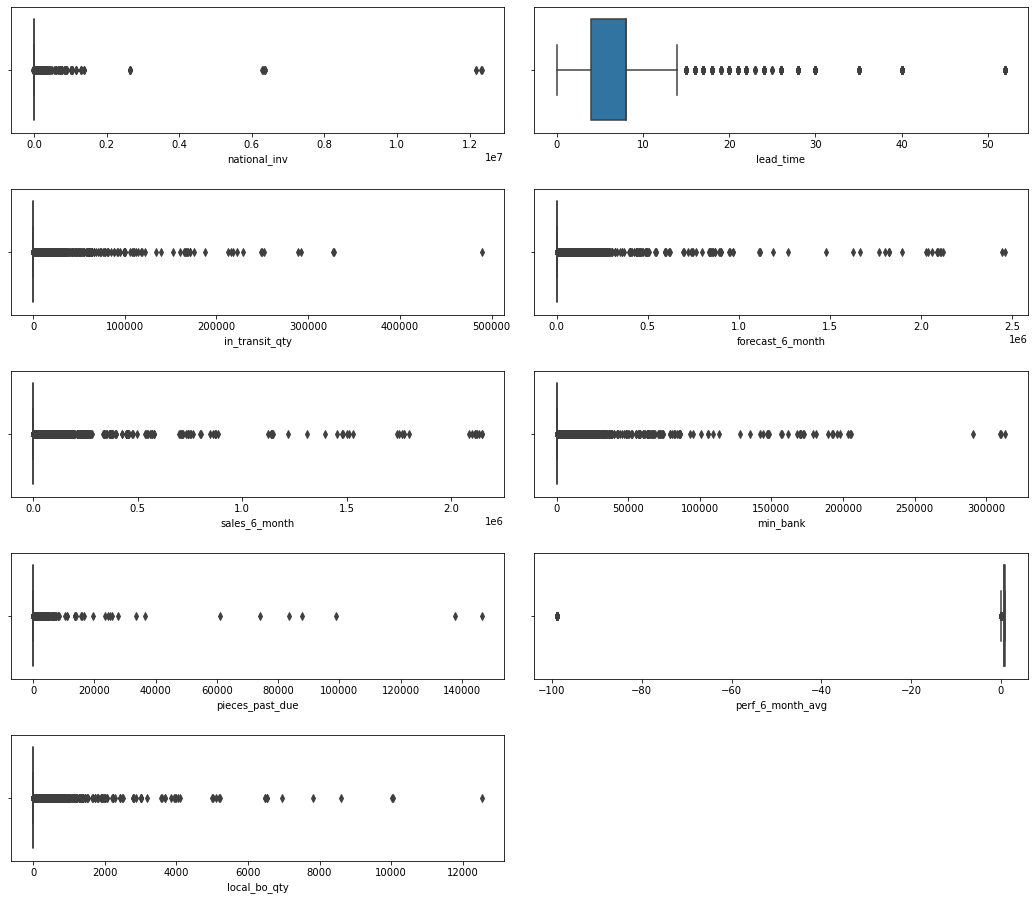

In [16]:
plt.figure(figsize=(15,20))
for index,col in enumerate(Xtrain.select_dtypes(include=np.number).columns):
    plt.subplot(8,2,index+1)
    plt.tight_layout(pad=2,h_pad=2)
    sns.boxplot(Xtrain[col])

In [17]:
print("Skewness in the numerical values of Xtrain")
Xtrain.skew()

Skewness in the numerical values of Xtrain


national_inv        347.601037
lead_time             4.694052
in_transit_qty      154.232710
forecast_6_month    138.734209
sales_6_month       138.713382
min_bank            126.405895
pieces_past_due     388.548725
perf_6_month_avg     -3.180772
local_bo_qty        171.573102
dtype: float64

In [18]:
print("Skewness in the numerical values of Xtest")
Xtest.skew()

Skewness in the numerical values of Xtest


national_inv        320.817286
lead_time             4.698560
in_transit_qty      194.065631
forecast_6_month    121.384881
sales_6_month       131.870319
min_bank            142.643572
pieces_past_due     262.006714
perf_6_month_avg     -3.180282
local_bo_qty        142.425008
dtype: float64

Inferences About Outliers - 
- We can observe that there are outliers in all numerical features.
- Except performance of 6 month average, all other features are heavy positive skewness.
- We can observe very extremely high outliers in all features.
- The triple digit skewness values indicate the outliers are extreme.
- We cannot cap such outliers due to being very far from whisker.
- We cannot also drop the values as they are many in number.
- Hence, we will use **power transformation to reduce the impact of outliers** since it can deal with both positive, negative and 0 value terms.

In [19]:
PT = PowerTransformer().fit(Xtrain.select_dtypes(include=np.number))

Xtrain[Xtrain.select_dtypes(include=np.number).columns] = PT.transform(Xtrain.select_dtypes(include=np.number))
Xtest[Xtest.select_dtypes(include=np.number).columns] = PT.transform(Xtest.select_dtypes(include=np.number))

In [20]:
logger.info("Numerical Features successfully transformed using Power transformation to treat the impact of extreme outliers")

2021-10-04 10:20:04 INFO-Numerical Features successfully transformed using Power transformation to treat the impact of extreme outliers


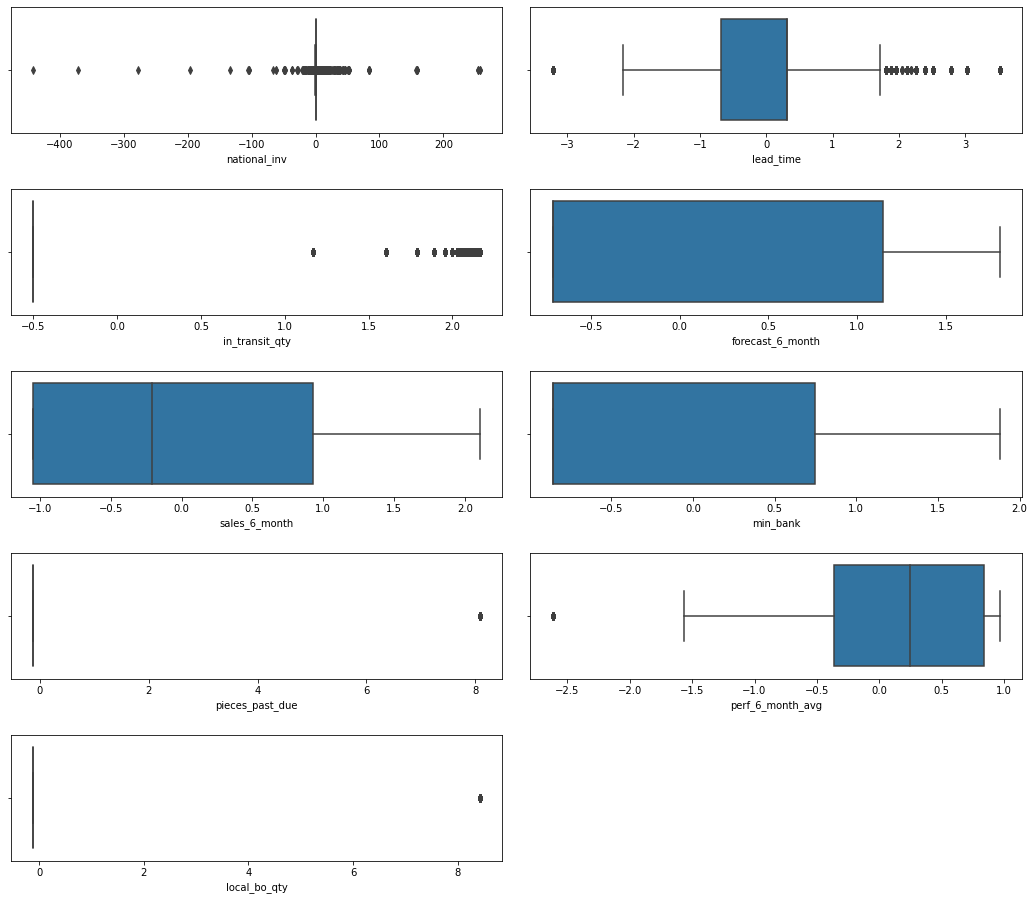

In [21]:
plt.figure(figsize=(15,20))
for index,col in enumerate(Xtrain.select_dtypes(include=np.number).columns):
    plt.subplot(8,2,index+1)
    plt.tight_layout(pad=2,h_pad=2)
    sns.boxplot(Xtrain[col])

In [22]:
print("Skewness in the numerical values of Xtrain after transformation")
Xtrain.skew()

Skewness in the numerical values of Xtrain after transformation


national_inv       -66.749326
lead_time            0.018895
in_transit_qty       1.532484
forecast_6_month     0.785492
sales_6_month        0.318216
min_bank             0.633564
pieces_past_due      7.961908
perf_6_month_avg    -1.351009
local_bo_qty         8.308472
dtype: float64

In [23]:
print("Skewness in the numerical values of Xtest after transformation")
Xtest.skew()

Skewness in the numerical values of Xtest after transformation


national_inv       -148.494042
lead_time             0.010282
in_transit_qty        1.546821
forecast_6_month      0.787866
sales_6_month         0.320459
min_bank              0.642570
pieces_past_due       8.039214
perf_6_month_avg     -1.348843
local_bo_qty          8.367713
dtype: float64

In [24]:
print("Number of records in train:",len(Xtrain))
print("Number of records in test:",len(Xtest))
print("Total records in train test combined:",len(X))

Number of records in train: 1181502
Number of records in test: 506358
Total records in train test combined: 1687860


## Encoding

In [25]:
Xtrain.select_dtypes(include=np.object).nunique()

potential_issue    2
deck_risk          2
oe_constraint      2
ppap_risk          2
stop_auto_buy      2
rev_stop           2
dtype: int64

Inferences - 

- Based on the analysis of the number of categories in each feature, we observe that all categorical features have only 2 categories.
- Due to less no. of unique categories, we can easily use **one hot encoding**

In [26]:
OHE = OneHotEncoder(drop="first").fit(Xtrain.select_dtypes(include=np.object))

Xtrain_OHE = pd.DataFrame(OHE.transform(Xtrain.select_dtypes(include=np.object)).toarray(),columns=OHE.get_feature_names(),index=Xtrain.index)
Xtest_OHE = pd.DataFrame(OHE.transform(Xtest.select_dtypes(include=np.object)).toarray(),columns=OHE.get_feature_names(),index=Xtest.index)

In [27]:
Xtrain.head()

,national_inv,lead_time,in_transit_qty,forecast_6_month,sales_6_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
1314790,-0.035304,-1.515638,-0.501005,-0.716707,-0.491927,0.120353,No,-0.123677,0.877671,-0.118664,No,No,No,Yes,No
411419,-0.050881,0.489817,-0.501005,-0.716707,0.458275,-0.858639,No,-0.123677,0.964001,-0.118664,No,No,No,Yes,No
1296471,0.091714,-0.682611,2.107086,1.695437,1.605824,1.609888,No,-0.123677,-0.060324,-0.118664,No,No,No,Yes,No
893198,-0.059466,0.489817,-0.501005,-0.716707,-1.049839,-0.858639,No,-0.123677,0.710215,-0.118664,Yes,No,No,Yes,No
1332269,0.010444,0.308412,2.160862,1.543047,1.416252,1.600473,No,-0.123677,0.710215,-0.118664,No,No,No,Yes,No


In [28]:
Xtrain_OHE.head()

,x0_Yes,x1_Yes,x2_Yes,x3_Yes,x4_Yes,x5_Yes
1314790,0.0,0.0,0.0,0.0,1.0,0.0
411419,0.0,0.0,0.0,0.0,1.0,0.0
1296471,0.0,0.0,0.0,0.0,1.0,0.0
893198,0.0,1.0,0.0,0.0,1.0,0.0
1332269,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
Xtrain = Xtrain.merge(Xtrain_OHE,left_index=True,right_index=True)
Xtest = Xtest.merge(Xtest_OHE,left_index=True,right_index=True)

In [30]:
print("Number of records in train:",len(Xtrain))
print("Number of records in test:",len(Xtest))
print("Total records in train test combined:",len(X))

Number of records in train: 1181502
Number of records in test: 506358
Total records in train test combined: 1687860


In [31]:
Xtrain.columns

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_6_month',
       'sales_6_month', 'min_bank', 'potential_issue', 'pieces_past_due',
       'perf_6_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'x0_Yes', 'x1_Yes', 'x2_Yes',
       'x3_Yes', 'x4_Yes', 'x5_Yes'],
      dtype='object')

In [32]:
Xtrain.head()

,national_inv,lead_time,in_transit_qty,forecast_6_month,sales_6_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,local_bo_qty,...,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,x0_Yes,x1_Yes,x2_Yes,x3_Yes,x4_Yes,x5_Yes
1314790,-0.035304,-1.515638,-0.501005,-0.716707,-0.491927,0.120353,No,-0.123677,0.877671,-0.118664,...,No,No,Yes,No,0.0,0.0,0.0,0.0,1.0,0.0
411419,-0.050881,0.489817,-0.501005,-0.716707,0.458275,-0.858639,No,-0.123677,0.964001,-0.118664,...,No,No,Yes,No,0.0,0.0,0.0,0.0,1.0,0.0
1296471,0.091714,-0.682611,2.107086,1.695437,1.605824,1.609888,No,-0.123677,-0.060324,-0.118664,...,No,No,Yes,No,0.0,0.0,0.0,0.0,1.0,0.0
893198,-0.059466,0.489817,-0.501005,-0.716707,-1.049839,-0.858639,No,-0.123677,0.710215,-0.118664,...,No,No,Yes,No,0.0,1.0,0.0,0.0,1.0,0.0
1332269,0.010444,0.308412,2.160862,1.543047,1.416252,1.600473,No,-0.123677,0.710215,-0.118664,...,No,No,Yes,No,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
ytrain.head()

,went_on_backorder
1314790,0
411419,0
1296471,0
893198,0
1332269,0


In [34]:
Xtrain.drop(["ppap_risk","stop_auto_buy","deck_risk","potential_issue","oe_constraint","rev_stop"],axis=1,inplace=True)
Xtest.drop(["ppap_risk","stop_auto_buy","deck_risk","potential_issue","oe_constraint","rev_stop"],axis=1,inplace=True)

In [35]:
logger.info("Categorical Features successfully one hot encoded")

2021-10-04 10:20:13 INFO-Categorical Features successfully one hot encoded


## Undersampling the Majority Class i.e No Backorders

#### Note - 
- Since the majority and minority classes have a drastic ratio of close to approx 99 to 1, we need to undersampe the majority classes in order to improve performance of model.
- However, in order to retain a little bit of the real life scenario in terms of balance of backorders and non backorders, we will maintain a ratio between the two in such as way that the ratio is around 25:75 or 1:3.
- To undersample, we will use **NearMiss technique**.

In [36]:
nums = ['national_inv', 'lead_time', 'in_transit_qty', 'forecast_6_month',
       'sales_6_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg',
       'local_bo_qty']

In [37]:
X = Xtrain.append(Xtest)
y = ytrain.append(ytest)
logger.info("Combined processed train and test samples into 1 bigger sample for undersampling")


2021-10-04 10:20:13 INFO-Combined processed train and test samples into 1 bigger sample for undersampling


In [38]:
Xtrain.head()

,national_inv,lead_time,in_transit_qty,forecast_6_month,sales_6_month,min_bank,pieces_past_due,perf_6_month_avg,local_bo_qty,x0_Yes,x1_Yes,x2_Yes,x3_Yes,x4_Yes,x5_Yes
1314790,-0.035304,-1.515638,-0.501005,-0.716707,-0.491927,0.120353,-0.123677,0.877671,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
411419,-0.050881,0.489817,-0.501005,-0.716707,0.458275,-0.858639,-0.123677,0.964001,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
1296471,0.091714,-0.682611,2.107086,1.695437,1.605824,1.609888,-0.123677,-0.060324,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
893198,-0.059466,0.489817,-0.501005,-0.716707,-1.049839,-0.858639,-0.123677,0.710215,-0.118664,0.0,1.0,0.0,0.0,1.0,0.0
1332269,0.010444,0.308412,2.160862,1.543047,1.416252,1.600473,-0.123677,0.710215,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0


In [39]:
X.head()

,national_inv,lead_time,in_transit_qty,forecast_6_month,sales_6_month,min_bank,pieces_past_due,perf_6_month_avg,local_bo_qty,x0_Yes,x1_Yes,x2_Yes,x3_Yes,x4_Yes,x5_Yes
1314790,-0.035304,-1.515638,-0.501005,-0.716707,-0.491927,0.120353,-0.123677,0.877671,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
411419,-0.050881,0.489817,-0.501005,-0.716707,0.458275,-0.858639,-0.123677,0.964001,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
1296471,0.091714,-0.682611,2.107086,1.695437,1.605824,1.609888,-0.123677,-0.060324,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
893198,-0.059466,0.489817,-0.501005,-0.716707,-1.049839,-0.858639,-0.123677,0.710215,-0.118664,0.0,1.0,0.0,0.0,1.0,0.0
1332269,0.010444,0.308412,2.160862,1.543047,1.416252,1.600473,-0.123677,0.710215,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0


In [40]:
X.tail()

,national_inv,lead_time,in_transit_qty,forecast_6_month,sales_6_month,min_bank,pieces_past_due,perf_6_month_avg,local_bo_qty,x0_Yes,x1_Yes,x2_Yes,x3_Yes,x4_Yes,x5_Yes
146560,-0.053579,-1.515638,-0.501005,1.494662,0.946017,0.899052,-0.123677,0.248210,-0.118664,0.0,1.0,0.0,0.0,1.0,0.0
453990,-0.071556,0.308412,-0.501005,0.049201,-1.049839,0.120353,-0.123677,-0.808003,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
1191947,-0.070334,0.308412,-0.501005,-0.716707,-1.049839,-0.858639,-0.123677,0.920617,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
2059,0.004279,0.308412,-0.501005,-0.716707,1.056314,1.249210,-0.123677,0.471779,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
854998,0.145673,0.308412,2.128799,-0.716707,1.422316,1.622583,-0.123677,0.920617,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0


In [41]:
Xtest.tail()

,national_inv,lead_time,in_transit_qty,forecast_6_month,sales_6_month,min_bank,pieces_past_due,perf_6_month_avg,local_bo_qty,x0_Yes,x1_Yes,x2_Yes,x3_Yes,x4_Yes,x5_Yes
146560,-0.053579,-1.515638,-0.501005,1.494662,0.946017,0.899052,-0.123677,0.248210,-0.118664,0.0,1.0,0.0,0.0,1.0,0.0
453990,-0.071556,0.308412,-0.501005,0.049201,-1.049839,0.120353,-0.123677,-0.808003,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
1191947,-0.070334,0.308412,-0.501005,-0.716707,-1.049839,-0.858639,-0.123677,0.920617,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
2059,0.004279,0.308412,-0.501005,-0.716707,1.056314,1.249210,-0.123677,0.471779,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
854998,0.145673,0.308412,2.128799,-0.716707,1.422316,1.622583,-0.123677,0.920617,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0


In [42]:
print("Number of records in train:",len(Xtrain))
print("Number of records in test:",len(Xtest))
print("Total records in train test combined:",len(X))

Number of records in train: 1181502
Number of records in test: 506358
Total records in train test combined: 1687860


In [43]:
SC = StandardScaler().fit(X[list(nums)])
X[list(nums)] = SC.transform(X[list(nums)])
logger.info("Numerical features scaled for the purpose of undersampling")


2021-10-04 10:20:14 INFO-Numerical features scaled for the purpose of undersampling


In [44]:
Xtrain.shape

(1181502, 15)

In [45]:
Xtest.shape

(506358, 15)

In [46]:
! pip install imblearn

In [47]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from collections import Counter

NM = NearMiss(sampling_strategy=0.25)
X_under , y_under = NM.fit_resample(X,y)
logger.info("Majority Class undersampled to make it 3 times the count of minority class instances")

2021-10-04 10:25:23 INFO-Majority Class undersampled to make it 3 times the count of minority class instances


In [48]:
print(f"befor Undersampling: {y.value_counts().to_dict()}")
print(f"After Undersampling using NearMiss technique {y_under.value_counts().to_dict()}")

befor Undersampling: {(0,): 1676567, (1,): 11293}
After Undersampling using NearMiss technique {(0,): 45172, (1,): 11293}


In [49]:
X_under[list(nums)] = SC.inverse_transform(X_under[list(nums)])

In [50]:
X_under.head()

,national_inv,lead_time,in_transit_qty,forecast_6_month,sales_6_month,min_bank,pieces_past_due,perf_6_month_avg,local_bo_qty,x0_Yes,x1_Yes,x2_Yes,x3_Yes,x4_Yes,x5_Yes
0,-0.071556,0.308412,-0.501005,-0.716707,-1.049839,-0.858639,-0.123677,0.920617,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.071556,0.308412,-0.501005,-0.716707,-1.049839,-0.858639,-0.123677,-2.618379,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.068315,0.308412,-0.501005,-0.716707,-1.049839,0.120353,-0.123677,0.877671,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.071556,0.308412,-0.501005,-0.716707,-1.049839,-0.858639,-0.123677,-2.618379,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.069277,0.308412,-0.501005,-0.716707,-1.049839,-0.858639,-0.123677,0.358166,-0.118664,0.0,0.0,0.0,0.0,1.0,0.0


In [51]:
X_under.to_csv("X_undersampled.csv")
y_under.to_csv("Y_undersampled.csv")

## Splitting Into Train and Test for model building

In [52]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X_under,y_under,test_size=0.30,random_state=0,stratify=y_under)
logger.info("Data Split into train and test samples for model building")


2021-10-04 10:25:26 INFO-Data Split into train and test samples for model building


In [53]:
Xtrain.to_csv("xtrain.csv")
Xtest.to_csv("xtest.csv")
ytrain.to_csv("ytrain.csv")
ytest.to_csv("ytest.csv")
logger.info("train and test samples saved for model building in script 3.")


2021-10-04 10:25:27 INFO-train and test samples saved for model building in script 3.
